In [1]:
import os
import sys
from pathlib import Path

import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from openvino.runtime import Core
from openvino.tools.mo import mo_tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Input,GlobalAveragePooling2D, Dropout
# from keras.models import Model
# import keras.backend, keras.mixed_precision
import tensorflow_addons as tfa


# sys.path.append("../utils")
# from notebook_utils import download_file

In [2]:
import os

import numpy as np

import shutil

directory_root = '../training_data'

allFileNames = os.listdir(directory_root)

pitted_files = [x for x in allFileNames if (x[0] == 'P' or x[0] == 'p')]
non_pitted_iles = [x for x in allFileNames if (x[0] == 'N' or x[0] == 'n')]

allFileNames_dir = {'Pitted': pitted_files,
                'NotPitted': non_pitted_iles}

In [3]:
len(pitted_files),len(non_pitted_iles),len(allFileNames)

(10760, 11075, 21835)

In [ ]:
for key,each_class in allFileNames_dir.items():
    
    np.random.seed(11111)
    np.random.shuffle(each_class)

    test_ratio = 0.2

    train_FileNames, test_FileNames = np.split(np.array(each_class),
                                                        [int(len(each_class) * (1 - test_ratio))])

    # train_FileNames = [directory_root + '/' + name for name in train_FileNames.tolist()]
    # test_FileNames = [directory_root + '/' + name for name in test_FileNames.tolist()]

    # for name in train_FileNames:
    #     shutil.copy(directory_root + '/' + name, '../split_files/' + key + '/train/')

    # for name in test_FileNames:
    #     shutil.copy(directory_root + '/' + name, '../split_files/' + key + '/test/')

    for name in train_FileNames:
        shutil.copy(directory_root + '/' + name, '../split_files2/' + 'train/' + key)

    for name in test_FileNames:
        shutil.copy(directory_root + '/' + name, '../split_files2/' + 'test/' + key)


In [4]:
from PIL import Image
path = r"../split_files/Pitted/Train/P (17).png" #r is meant for ignoring spaces in the path
ex_image = Image.open(path)

In [5]:
a = ex_image.getbands()
color_mode = ''
for x in a:
    color_mode = color_mode + x
color_mode = color_mode.lower()
color_mode

'rgb'

In [6]:
n_channel = len(ex_image.getbands())
n_channel, ex_image.size

(3, (150, 150))

In [7]:
from keras.applications.efficientnet_v2 import EfficientNetV2L
import tensorflow as tf

from keras.utils import image_dataset_from_directory
from keras.layers import Dense,Input,GlobalAveragePooling2D, Dropout
from keras.models import Model
import keras.backend, keras.mixed_precision
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt

In [8]:
#Getting the appropriate image shape for the chosen model either vaildate the given input shape or use default shape of the model 
from keras.applications import imagenet_utils
include_top = False
weights='imagenet'
input_shape = (ex_image.size[0],ex_image.size[1],n_channel)
input_shape = imagenet_utils.obtain_input_shape(input_shape,default_size=480,        
         min_size=32,
         data_format=keras.backend.image_data_format(),
         require_flatten=include_top,
         weights="imagenet"
         if weights in {"imagenet", "imagenet-21k", "imagenet-21k-ft1k"}
         else weights,
)
input_shape

(150, 150, 3)

In [9]:
#some of the kernel functions to apply or use during Dense operations at the top of the layer
CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {"scale": 2.0, "mode": "fan_out", "distribution": "truncated_normal"},
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {"scale": 1.0 / 3.0, "mode": "fan_out", "distribution": "uniform"},
}

In [10]:
training_data_path = "../split_files2/train"
test_data_path = "../split_files2/test"
seed = 11111
batch_size = 32
epochs = 25

In [11]:


#create a method that ingests the data and prepares it for analysis, this way I can call the method once for the training set, 
# again for the validation set and later for the test set and know that they have been prepared in the same way.
# Optimise the training performance to make best use of the memory and compute available

def get_image_data(data_path, label_mode, color_mode, batch_size, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = image_dataset_from_directory(
    data_path,
    labels='inferred',
    label_mode = label_mode,
    color_mode = color_mode,
    batch_size = batch_size,
    image_size = image_size,
    seed=seed,
    validation_split=validation_split,
    subset=subset,
    interpolation='lanczos5',
    crop_to_aspect_ratio=False,
    )

    raw_data_set.class_names.sort()
    
    #alter the return type from being the FetchedDataset to being a dict containing the FetchedDataset and the list of class names.
    # return raw_data_set
    return {
        "data": raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
        ),
        "classNames": raw_data_set.class_names
    }

In [12]:
training_ds = get_image_data(
    training_data_path,
    'binary',
    color_mode,
    batch_size,
    input_shape[0:-1],
    seed,
    subset = "training",
    validation_split = 0.2
)
validation_ds = get_image_data(
    training_data_path,
    'binary',
    color_mode,
    batch_size,
    input_shape[0:-1],
    seed,
    subset = "validation",
    validation_split = 0.2
)
test_ds = get_image_data(
    test_data_path,
    'binary',
    color_mode,
    batch_size,
    input_shape[0:-1],
    seed,
)

Found 20999 files belonging to 2 classes.
Using 16800 files for training.
Found 20999 files belonging to 2 classes.
Using 4199 files for validation.
Found 7898 files belonging to 2 classes.


In [13]:
# sanity check to ensure that the name and number of classes are the same in both sets and 
# then store the number of classes for classification to use in defining the output shape of the model.
equivalence_check = training_ds["classNames"] == validation_ds["classNames"]
assert_fail_message = "Training and Validation classes should match"
assert(equivalence_check), assert_fail_message
class_names = training_ds["classNames"]
n_classes = len(class_names)
n_classes, class_names

(2, ['NotPitted', 'Pitted'])

(32, 150, 150, 3)
tf.Tensor([116. 112. 103.], shape=(3,), dtype=float32)


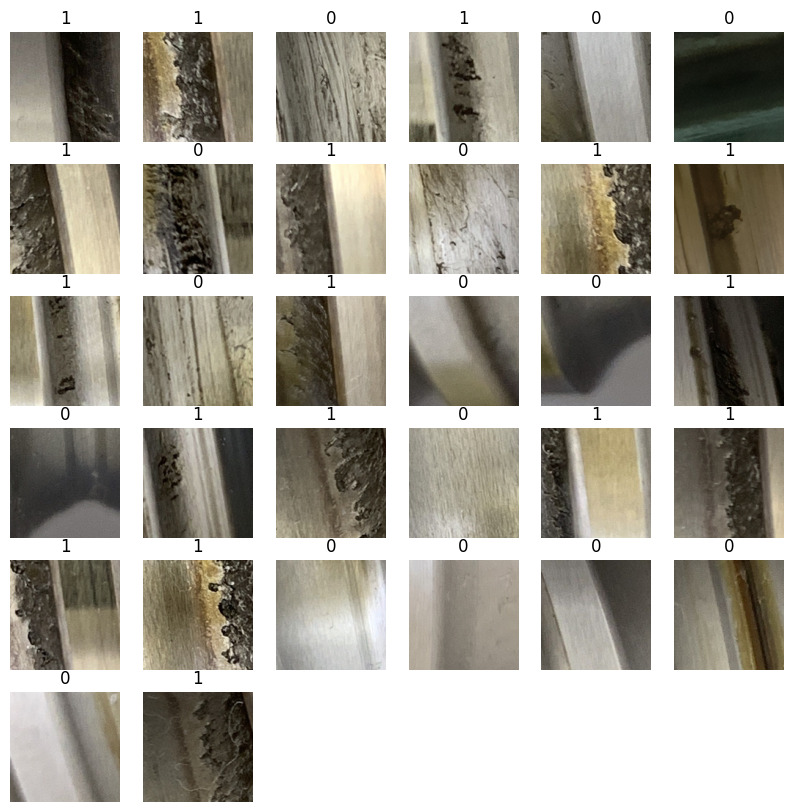

In [14]:
# plt.figure(figsize=(10, 10))
# for i, (image, label) in enumerate(training_ds['data'].take(1)):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image)
#     plt.title(int(label))
#     plt.axis("off")


for images, labels in training_ds['data'].take(1):
    print(images.shape)
    print(images[0,0,0,:])
    # print(labels)
    plt.figure(figsize=(10, 10))

    for i in range(len(labels)):
        ax = plt.subplot(6, 6, i + 1)
        # augmented_image = data_augmentation(
        #     tf.expand_dims(first_image, 0), training=True
        # )
        #augmented_image = tf.expand_dims(images[i], 0)
        plt.imshow(images[i].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
inputs = Input(input_shape)
#scale_layer = keras.layers.Rescaling(scale = 1.0 / 127.5, offset = -1 )
#x = scale_layer(inputs)
base_model3 = EfficientNetV2L(weights=weights, input_shape = input_shape, include_top=include_top) # Do not include the ImageNet classifier at the top.
base_model3.trainable = False
# x = base_model3(inputs, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)  # Regularize with dropout
# x = Dense(1024, activation='relu')(x)
# outputs = Dense(1,activation = 'sigmoid',kernel_initializer=DENSE_KERNEL_INITIALIZER)(x)
# model3 = Model(inputs, outputs)
# model3.summary()

In [18]:
#Train the model on new data.
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor
lr = 1e-2 * schedule(step)
wd = 1e-4 * schedule(step)
#wd = 1e-4 * schedule(step)

In [19]:
loss_fn = keras.losses.BinaryCrossentropy()
#optimizer = keras.optimizers.adamw_experimental.AdamW(learning_rate=lr)
opt = tfa.optimizers.AdamW(learning_rate=tf.Variable(lr), weight_decay=tf.Variable(wd))
#opt = keras.optimizers.Adam(learning_rate=lr)
optimizer = tfa.optimizers.Lookahead(opt)
metrics = [keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()]

In [30]:
model4 = tf.keras.models.Sequential([keras.Input(input_shape),   
                                        base_model3,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(1024, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(1,activation = 'sigmoid',kernel_initializer=DENSE_KERNEL_INITIALIZER)
                                ])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 5, 5, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 119,059,617
Trainable params: 1,312,769


In [20]:

# model3.compile(
#     optimizer = optimizer,
#     loss = loss_fn,
#     metrics = metrics
# )

# callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',
#     baseline=None, restore_best_weights=True
# )

# history3 = model3.fit(
#     training_ds["data"],
#     validation_data = validation_ds["data"],
#     epochs = epochs,
#     callbacks = [callback],
#     steps_per_epoch= len(training_ds["data"]) // batch_size,

# )


In [21]:
# model3.evaluate(test_ds['data'])

In [22]:
# model3.save("../path_to_my_model3_stepped")
# # Recreate the exact same model purely from the file:
# model3_reload = keras.models.load_model("../path_to_my_model3_stepped")

In [23]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["binary_accuracy"])
    plt.plot(hist.history["val_binary_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

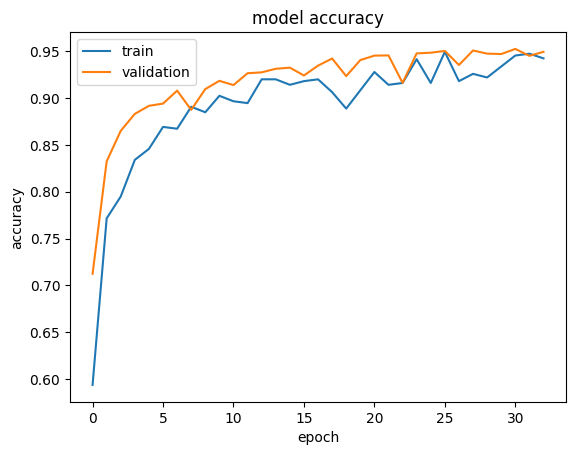

In [47]:
#history3.history

plot_hist(history3)

In [48]:
import pandas as pd

effnetv2l_pd = pd.DataFrame(history3.history)
effnetv2l_pd


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,1.004622,0.593750,0.749508,0.712312
1,0.600661,0.771484,0.413752,0.832341
2,0.519780,0.794922,0.326606,0.864968
3,0.424661,0.833984,0.282888,0.883067
4,0.387251,0.845703,0.264817,0.891641
5,0.338370,0.869141,0.263574,0.894022
6,0.316806,0.867188,0.226740,0.907835
7,0.322006,0.890625,0.267626,0.887354
8,0.294366,0.884766,0.218092,0.909502
9,0.252034,0.902344,0.205568,0.918314


In [31]:

# #let's visualize layer names and layer indices to see how many layers

for i, layer in enumerate(base_model3.layers):
       print(i, layer.name)

0 input_2
1 rescaling
2 stem_conv
3 stem_bn
4 stem_activation
5 block1a_project_conv
6 block1a_project_bn
7 block1a_project_activation
8 block1a_add
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block1c_project_conv
15 block1c_project_bn
16 block1c_project_activation
17 block1c_drop
18 block1c_add
19 block1d_project_conv
20 block1d_project_bn
21 block1d_project_activation
22 block1d_drop
23 block1d_add
24 block2a_expand_conv
25 block2a_expand_bn
26 block2a_expand_activation
27 block2a_project_conv
28 block2a_project_bn
29 block2b_expand_conv
30 block2b_expand_bn
31 block2b_expand_activation
32 block2b_project_conv
33 block2b_project_bn
34 block2b_drop
35 block2b_add
36 block2c_expand_conv
37 block2c_expand_bn
38 block2c_expand_activation
39 block2c_project_conv
40 block2c_project_bn
41 block2c_drop
42 block2c_add
43 block2d_expand_conv
44 block2d_expand_bn
45 block2d_expand_activation
46 block2d_project_conv
47 block2d_proj

In [50]:
#Unfreeze model for fine tuning
def unfreeze_model(model,fr_pt=None):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    if fr_pt:
        model.trainable = True
        for layer in model.layers[0:fr_pt]:
            layer.trainable = False
        for layer in model.layers[fr_pt:]:
            if not isinstance(layer, keras.layers.BatchNormalization):
                layer.trainable = True
            else:
                layer.trainable = False
    else:
        model.trainable = False
        for layer in model.layers:
            layer.trainable = False

In [51]:
for i, layer in enumerate(model3.get_layer('efficientnetv2-l').layers):
       print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block1d_project_conv False
20 block1d_project_bn False
21 block1d_project_activation False
22 block1d_drop False
23 block1d_add False
24 block2a_expand_conv False
25 block2a_expand_bn False
26 block2a_expand_activation False
27 block2a_project_conv False
28 block2a_project_bn False
29 block2b_expand_conv False
30 block2b_expand_bn False
31 block2b_expand_activation False
32 block2b_project_conv False
33 block2b_project_bn False
34 block2b_drop False
35 block2b_add False
36 block2c_expand_conv False
37 block2c_expand

In [40]:
#for effnetv2l fr_pt = 922
fr_pt = 922
unfreeze_model(base_model3,fr_pt)

In [55]:
unfreeze_model(base_model3)

In [56]:
for i, layer in enumerate(model3.get_layer('efficientnetv2-l').layers):
       print(i, layer.name, layer.trainable)
       

0 input_2 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block1d_project_conv False
20 block1d_project_bn False
21 block1d_project_activation False
22 block1d_drop False
23 block1d_add False
24 block2a_expand_conv False
25 block2a_expand_bn False
26 block2a_expand_activation False
27 block2a_project_conv False
28 block2a_project_bn False
29 block2b_expand_conv False
30 block2b_expand_bn False
31 block2b_expand_activation False
32 block2b_project_conv False
33 block2b_project_bn False
34 block2b_drop False
35 block2b_add False
36 block2c_expand_conv False
37 block2c_expand

In [24]:
# Learning rate callback function
def get_lr_callback():
    def scheduler(epoch, lr):
        if epoch < 6:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
    return lr_callback

def stop_callback():
    return tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)


In [32]:
model4.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = metrics
)

history4_frz = model4.fit(
    training_ds["data"],
    validation_data = validation_ds["data"],
    epochs = epochs,
    callbacks = [get_lr_callback(),stop_callback()],
    steps_per_epoch= len(training_ds["data"]) // batch_size
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/25
16/16 [==============================] - 539s 35s/step - loss: 8.3675 - binary_accuracy: 0.7090 - auc: 0.7408 - val_loss: 2.0220 - val_binary_accuracy: 0.8445 - val_auc: 0.8755 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/25
16/16 [==============================] - 550s 36s/step - loss: 1.7990 - binary_accuracy: 0.8301 - auc: 0.8743 - val_loss: 1.1678 - val_binary_accuracy: 0.8712 - val_auc: 0.9149 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/25
16/16 [==============================] - 577s 38s/step - loss: 1.2122 - binary_accuracy: 0.8633 - auc: 0.9025 - val_loss: 0.5216 - val_binary_accuracy: 0.9159 - val_auc: 0.9544 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/25
16/16 [==============================] - 542s 36s/step - loss: 0.7667 

In [33]:
model4.save("../path_to_my_model4_stepped")
# Recreate the exact same model purely from the file:
model4_reload = keras.models.load_model("../path_to_my_model4_stepped")

INFO:tensorflow:Assets written to: ../path_to_my_model4_stepped\assets


INFO:tensorflow:Assets written to: ../path_to_my_model4_stepped\assets
